## Importer les librairies

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Charger le dataframe

In [10]:
df_final = pd.read_csv('../../Data/Cleaned_Dataframe.csv',sep=';')
colonnes_bool = ['ANTECEDENT_FAMILIAUX', 'DIABETE', 'EXPOSITION', 'ACOUPHENES']
for col in colonnes_bool:
    df_final[col] = df_final[col].replace({'True': True, 'False': False})
    df_final[col] = df_final[col].astype('boolean')  # gère aussi les <NA>
pd.set_option('display.max_columns', None)

C:\Users\benba\AppData\Local\Temp\ipykernel_22676\2578287721.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv('../../Data/Cleaned_Dataframe.csv',sep=';')


---
## Statistiques descriptives et graphes d'exploration

In [11]:
def display_statistics(df):
    # Choix de style
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)
    plt.rcParams['figure.figsize'] = (10, 6)

    # 2. Variables d’intérêt
    # - Variables numériques : AGE, FREQ_*
    num_features = ['AGE'] + [c for c in df.columns if c.startswith('FREQ_')]

    # 3. Statistiques descriptives globales et par groupe
    # 3.1 Résumé global
    display(df[num_features].describe().T)
    total = df.isna().sum()
    percent = 100 * df.isna().mean().round(3)
    dtypes = df.dtypes
    missing_df = pd.DataFrame({
        'type': dtypes,
        'nb_missing': total,
        'pct_missing': percent
    })
    display(missing_df)

    # 3.2 Résumé par présence d’acouphènes
    display(
        df
          .groupby('ACOUPHENES')[num_features]
          .agg(['mean','std','median','count'])
          .round(2)
    )
    # 4. Histogrammes et densités
    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # Antécédents familiaux
    sns.histplot(data=df, x=df['ANTECEDENT_FAMILIAUX'].astype(str), hue='ACOUPHENES',
                element='step', stat='density', common_norm=False, ax=axes[0])
    axes[0].set_title("Densité selon antécédents familiaux et selon acouphènes")

    # Exposition
    sns.histplot(data=df, x=df['EXPOSITION'].astype(str), hue='ACOUPHENES',
                element='step', stat='density', common_norm=False, ax=axes[1])
    axes[1].set_title("Densité selon exposition et selon acouphènes")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # Sexe
    sns.histplot(data=df, x=df['SEXE'].astype(str), hue='ACOUPHENES',
                element='step', stat='density', common_norm=False, ax=axes[0])
    axes[0].set_title("Densité selon sexe et selon acouphènes")

    # Diabete
    sns.histplot(data=df, x=df['DIABETE'].astype(str), hue='ACOUPHENES',
                element='step', stat='density', common_norm=False, ax=axes[1])
    axes[1].set_title("Densité selon diabète et selon acouphènes")

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 5))

    # Perte auditive
    sns.histplot(data=df, x='PERTE', hue='ACOUPHENES',
                 element='step', stat='density', common_norm=False, discrete=True, ax=ax
    )

    ax.set_title("Distribution of hearing loss according to tinnitus")

    plt.tight_layout()
    plt.show()

    # 5. Boxplots par fréquence
    # On prépare un DataFrame "long" pour seaborn
    df_long = (
        df
          .loc[:, ['ACOUPHENES'] + [c for c in df.columns if c.startswith('FREQ_')]]
          .melt(id_vars='ACOUPHENES',
                var_name='Fréquence',
                value_name='Seuil_dB')
    )

    plt.figure(figsize=(12,8))
    sns.boxplot(data=df_long, x='Fréquence', y='Seuil_dB', hue='ACOUPHENES')
    plt.xticks(rotation=45)
    plt.title("Seuils auditifs par fréquence et par présence d’acouphènes")
    plt.legend(title="Acouphènes", loc='upper left')
    plt.tight_layout()
    plt.show()

    # 6. Heatmap de corrélation
    corr = df[num_features].corr()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Corrélation'})
    plt.title("Matrice de corrélation des variables numériques")
    plt.tight_layout()
    plt.show()

    # 7. Pairplot
    sample_df = df.sample(frac=0.001, random_state=42)
    sns.pairplot(sample_df, vars=num_features, hue='ACOUPHENES', diag_kind='kde', corner=True)

On ajoute une variable qui catégorise le type de perte auditive, basé sur le test THR

In [12]:
thr_cols = [col for col in df_final.columns if col.startswith('FREQ_') and col.endswith('_THR')]
df_final['mean_thr'] = df_final[thr_cols].mean(axis=1)
def categoriser_perte(x):
    if x < 20:
        return 'Aucune'
    elif 20 <= x < 40:
        return 'Légère'
    elif 40 <= x < 60:
        return 'Moyenne'
    else:
        return 'Sévère'
df_final['PERTE'] = df_final['mean_thr'].apply(categoriser_perte)
df_final.drop(columns=['mean_thr'], inplace=True)
order_perte = ['Aucune', 'Légère', 'Moyenne', 'Sévère']
df_final['PERTE'] = pd.Categorical(
    df_final['PERTE'],
    categories=order_perte,
    ordered=True
)

On affiche les statistiques descriptives

count        mean        std   min   25%    50%    75%  \
AGE              62275.0   70.981630  12.875492   0.0  64.0   72.0   80.0   
FREQ_250_D_THR   62142.0   29.957742  14.743687 -10.0  20.0   25.0   40.0   
FREQ_250_G_THR   62121.0   29.761643  14.787735 -10.0  20.0   25.0   35.0   
FREQ_250_D_UCL   40699.0   94.953193   9.360011  10.0  90.0   95.0  100.0   
FREQ_250_G_UCL   40582.0   95.234488   9.328422  15.0  90.0  100.0  100.0   
FREQ_500_D_THR   62275.0   32.140265  15.399903 -10.0  20.0   30.0   40.0   
FREQ_500_G_THR   62275.0   31.946977  15.550911 -10.0  20.0   30.0   40.0   
FREQ_500_D_UCL   62275.0   97.427957  19.188000   0.0  90.0  100.0  110.0   
FREQ_500_G_UCL   62275.0   97.758956  19.609337   0.0  90.0  100.0  110.0   
FREQ_1000_D_THR  62275.0   36.065660  15.884413  -5.0  25.0   35.0   45.0   
FREQ_1000_G_THR  62275.0   35.592132  16.302145 -10.0  25.0   35.0   45.0   
FREQ_1000_D_UCL  62275.0  100.351168  14.111292   0.0  95.0  100.0  110.0   
FREQ_1000_G_UCL  62275.0  100.637607  14.073215   0.0  95.0  100.0  110.0   
FREQ_2000_D_THR  62275.0   44.676692  17.209211  -5.0  35.0   45.0   55.0   
FREQ_2000_G_THR  62275.0   45.447981  17.600139  -5.0  35.0   45.0   55.0   
FREQ_2000_D_UCL  62275.0  101.003452  14.490734   0.0  95.0  105.0  110.0   
FREQ_2000_G_UCL  62275.0  101.469803  14.733991   0.0  95.0  105.0  110.0   
FREQ_4000_D_THR  62275.0   57.599920  19.081515 -10.0  45.0   60.0   70.0   
FREQ_4000_G_THR  62275.0   58.977246  18.997683 -10.0  50.0   60.0   70.0   
FREQ_4000_D_UCL  62275.0  101.175961  19.436397   0.0  95.0  105.0  110.0   
FREQ_4000_G_UCL  62275.0  101.637800  19.661088   0.0  95.0  105.0  110.0   
FREQ_8000_D_THR  59028.0   66.608643  21.160832 -10.0  55.0   70.0   80.0   
FREQ_8000_G_THR  59096.0   67.452010  20.759942 -10.0  55.0   70.0   80.0   
FREQ_8000_D_UCL  16912.0   96.858444  11.335324   5.0  90.0  100.0  105.0   
FREQ_8000_G_UCL  16883.0   97.258544  11.184754  -5.0  95.0  100.0  105.0   

                   max  
AGE              103.0  
FREQ_250_D_THR   110.0  
FREQ_250_G_THR   110.0  
FREQ_250_D_UCL   120.0  
FREQ_250_G_UCL   120.0  
FREQ_500_D_THR   115.0  
FREQ_500_G_THR   115.0  
FREQ_500_D_UCL   120.0  
FREQ_500_G_UCL   120.0  
FREQ_1000_D_THR  120.0  
FREQ_1000_G_THR  120.0  
FREQ_1000_D_UCL  120.0  
FREQ_1000_G_UCL  125.0  
FREQ_2000_D_THR  120.0  
FREQ_2000_G_THR  120.0  
FREQ_2000_D_UCL  125.0  
FREQ_2000_G_UCL  120.0  
FREQ_4000_D_THR  120.0  
FREQ_4000_G_THR  120.0  
FREQ_4000_D_UCL  125.0  
FREQ_4000_G_UCL  125.0  
FREQ_8000_D_THR  120.0  
FREQ_8000_G_THR  120.0  
FREQ_8000_D_UCL  125.0  
FREQ_8000_G_UCL  125.0

type  nb_missing  pct_missing
ID_CLIENT               object           0          0.0
ANTECEDENT_FAMILIAUX   boolean        2655          4.3
ACOUPHENES             boolean           0          0.0
DIABETE                boolean        2534          4.1
EXPOSITION             boolean        1463          2.3
AGE                    float64           0          0.0
SEXE                    object          19          0.0
FREQ_250_D_THR         float64         133          0.2
FREQ_250_G_THR         float64         154          0.2
FREQ_250_D_UCL         float64       21576         34.6
FREQ_250_G_UCL         float64       21693         34.8
FREQ_500_D_THR         float64           0          0.0
FREQ_500_G_THR         float64           0          0.0
FREQ_500_D_UCL         float64           0          0.0
FREQ_500_G_UCL         float64           0          0.0
FREQ_1000_D_THR        float64           0          0.0
FREQ_1000_G_THR        float64           0          0.0
FREQ_1000_D_UCL        float64           0          0.0
FREQ_1000_G_UCL        float64           0          0.0
FREQ_2000_D_THR        float64           0          0.0
FREQ_2000_G_THR        float64           0          0.0
FREQ_2000_D_UCL        float64           0          0.0
FREQ_2000_G_UCL        float64           0          0.0
FREQ_4000_D_THR        float64           0          0.0
FREQ_4000_G_THR        float64           0          0.0
FREQ_4000_D_UCL        float64           0          0.0
FREQ_4000_G_UCL        float64           0          0.0
FREQ_8000_D_THR        float64        3247          5.2
FREQ_8000_G_THR        float64        3179          5.1
FREQ_8000_D_UCL        float64       45363         72.8
FREQ_8000_G_UCL        float64       45392         72.9
PERTE                 category           0          0.0

AGE                      FREQ_250_D_THR                       \
             mean    std median  count           mean    std median  count   
ACOUPHENES                                                                   
False       72.75  12.66   74.0  33177          30.64  14.61   30.0  33125   
True        68.96  12.82   70.0  29098          29.18  14.85   25.0  29017   

           FREQ_250_G_THR                      FREQ_250_D_UCL               \
                     mean    std median  count           mean   std median   
ACOUPHENES                                                                   
False               30.40  14.65   30.0  33114          95.36  8.98  100.0   
True                29.03  14.91   25.0  29007          94.49  9.76   95.0   

                  FREQ_250_G_UCL                     FREQ_500_D_THR         \
            count           mean   std median  count           mean    std   
ACOUPHENES                                                                   
False       21641          95.64  8.96  100.0  21589          33.00  15.24   
True        19058          94.78  9.71   95.0  18993          31.16  15.53   

                         FREQ_500_G_THR                      FREQ_500_D_UCL  \
           median  count           mean    std median  count           mean   
ACOUPHENES                                                                    
False        30.0  33177          32.77  15.39   30.0  33177          98.13   
True         30.0  29098          31.01  15.68   30.0  29098          96.63   

                                FREQ_500_G_UCL                       \
              std median  count           mean    std median  count   
ACOUPHENES                                                            
False       18.81  100.0  33177          98.46  19.19  100.0  33177   
True        19.58  100.0  29098          96.96  20.04  100.0  29098   

           FREQ_1000_D_THR                      FREQ_1000_G_THR                \
                      mean    std median  count            mean    std median   
ACOUPHENES                                                                      
False                37.13  15.71   35.0  33177           36.65  16.15   35.0   
True                 34.85  16.00   35.0  29098           34.38  16.39   35.0   

                  FREQ_1000_D_UCL                      FREQ_1000_G_UCL         \
            count            mean    std median  count            mean    std   
ACOUPHENES                                                                      
False       33177          101.13  13.72  100.0  33177          101.33  13.84   
True        29098           99.46  14.50  100.0  29098           99.85  14.30   

                         FREQ_2000_D_THR                      FREQ_2000_G_THR  \
           median  count            mean    std median  count            mean   
ACOUPHENES                                                                      
False       105.0  33177           45.76  16.93   45.0  33177           46.46   
True        100.0  29098           43.44  17.44   45.0  29098           44.29   

                                FREQ_2000_D_UCL                       \
              std median  count            mean    std median  count   
ACOUPHENES                                                             
False       17.31   45.0  33177          101.82  14.11  105.0  33177   
True        17.85   45.0  29098          100.07  14.86  100.0  29098   

           FREQ_2000_G_UCL                      FREQ_4000_D_THR                \
                      mean    std median  count            mean    std median   
ACOUPHENES                                                                      
False               102.17  14.46  105.0  33177           58.04  18.99   60.0   
True                100.67  15.00  105.0  29098           57.10  19.17   60.0   

                  FREQ_4000_G_THR                      FREQ_4000_D_UCL         \
            count      

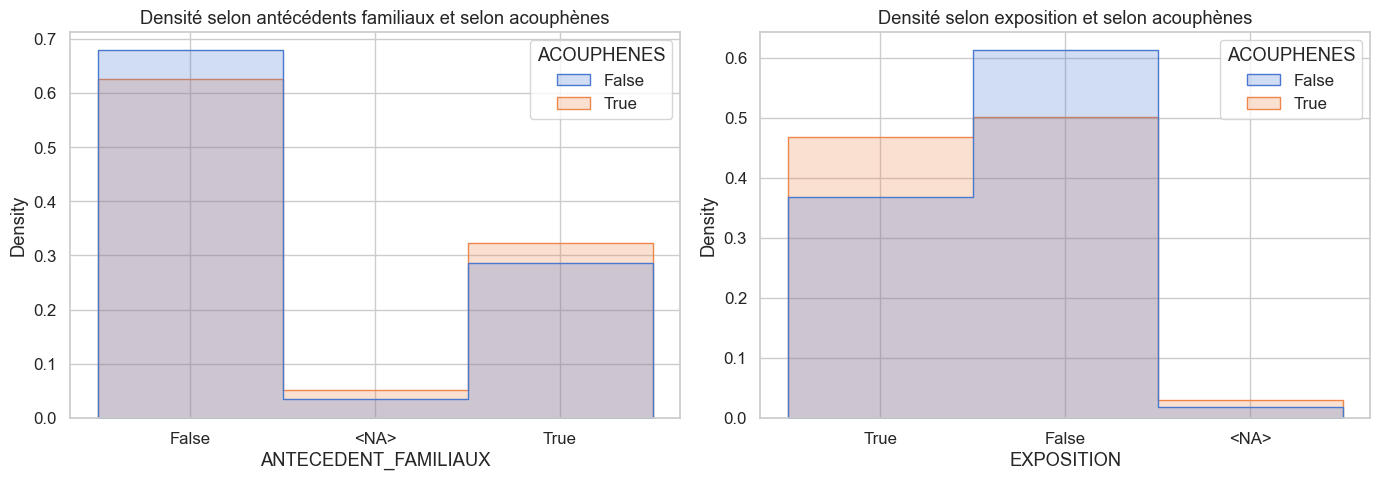

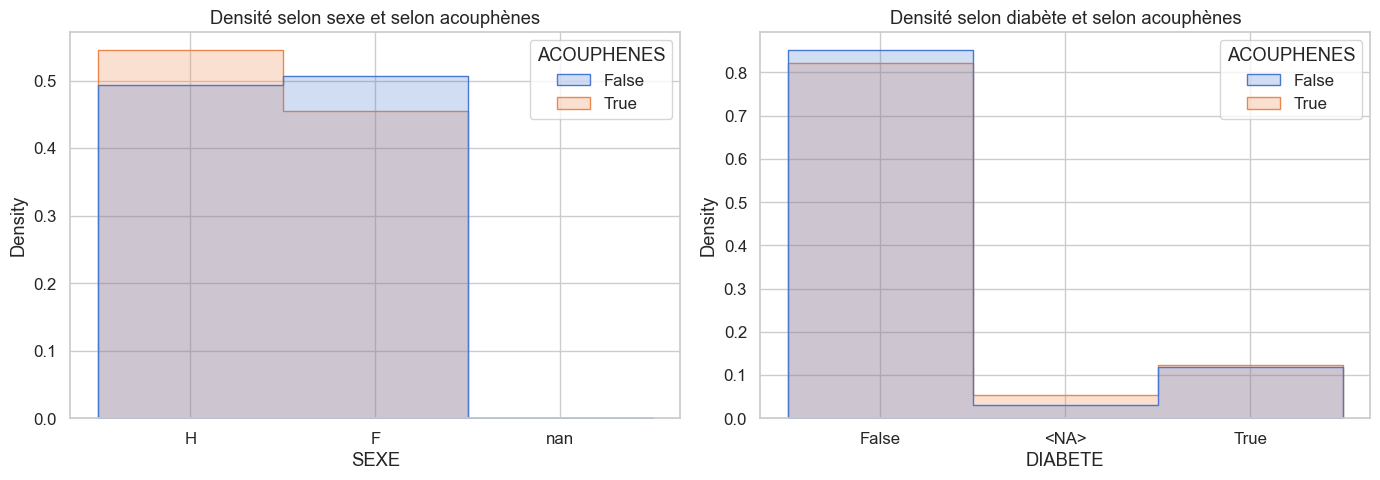

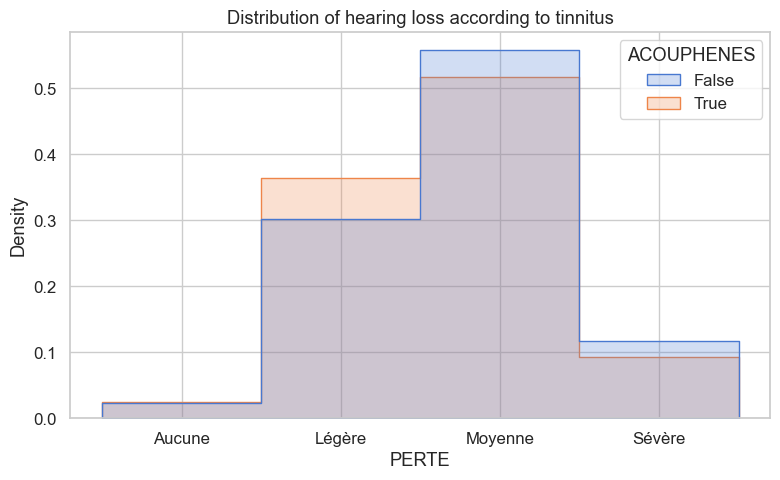

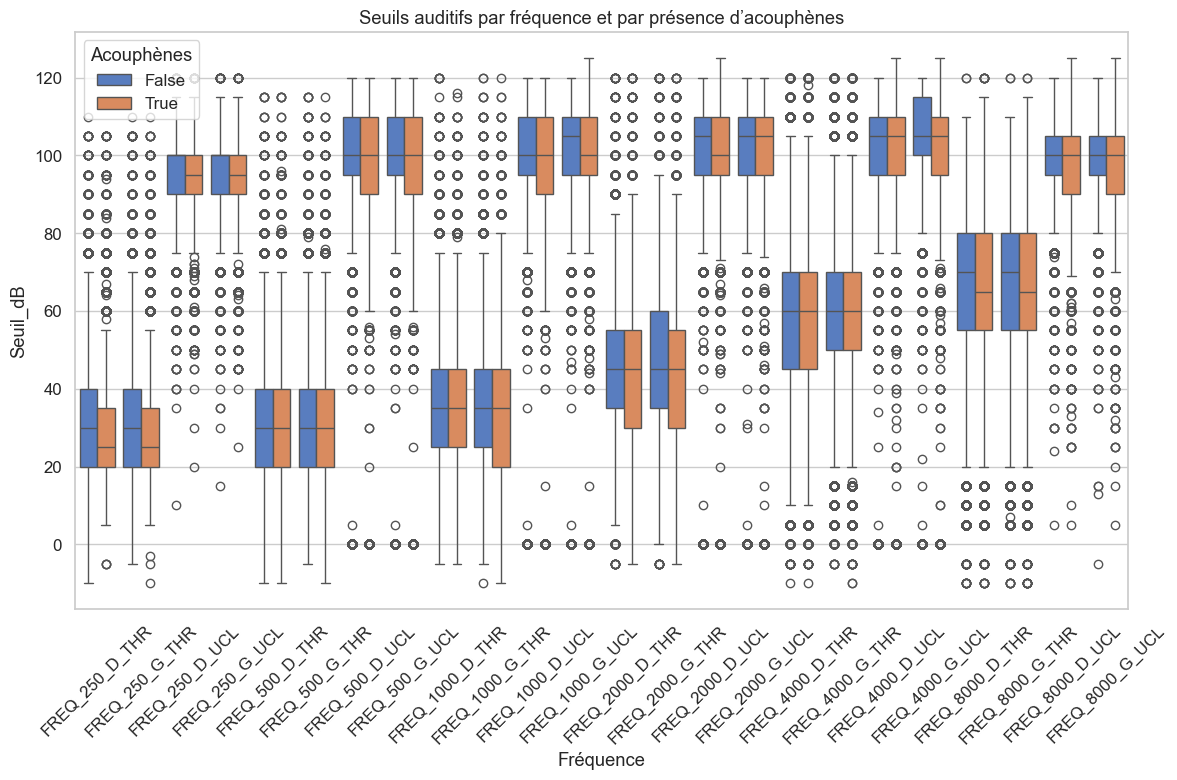

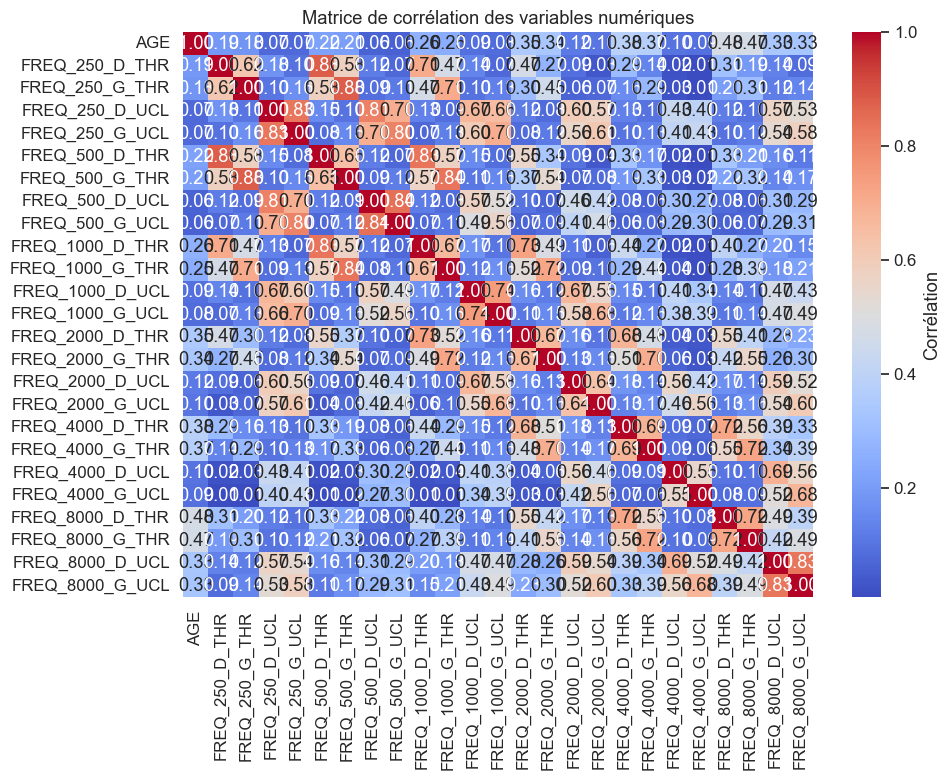

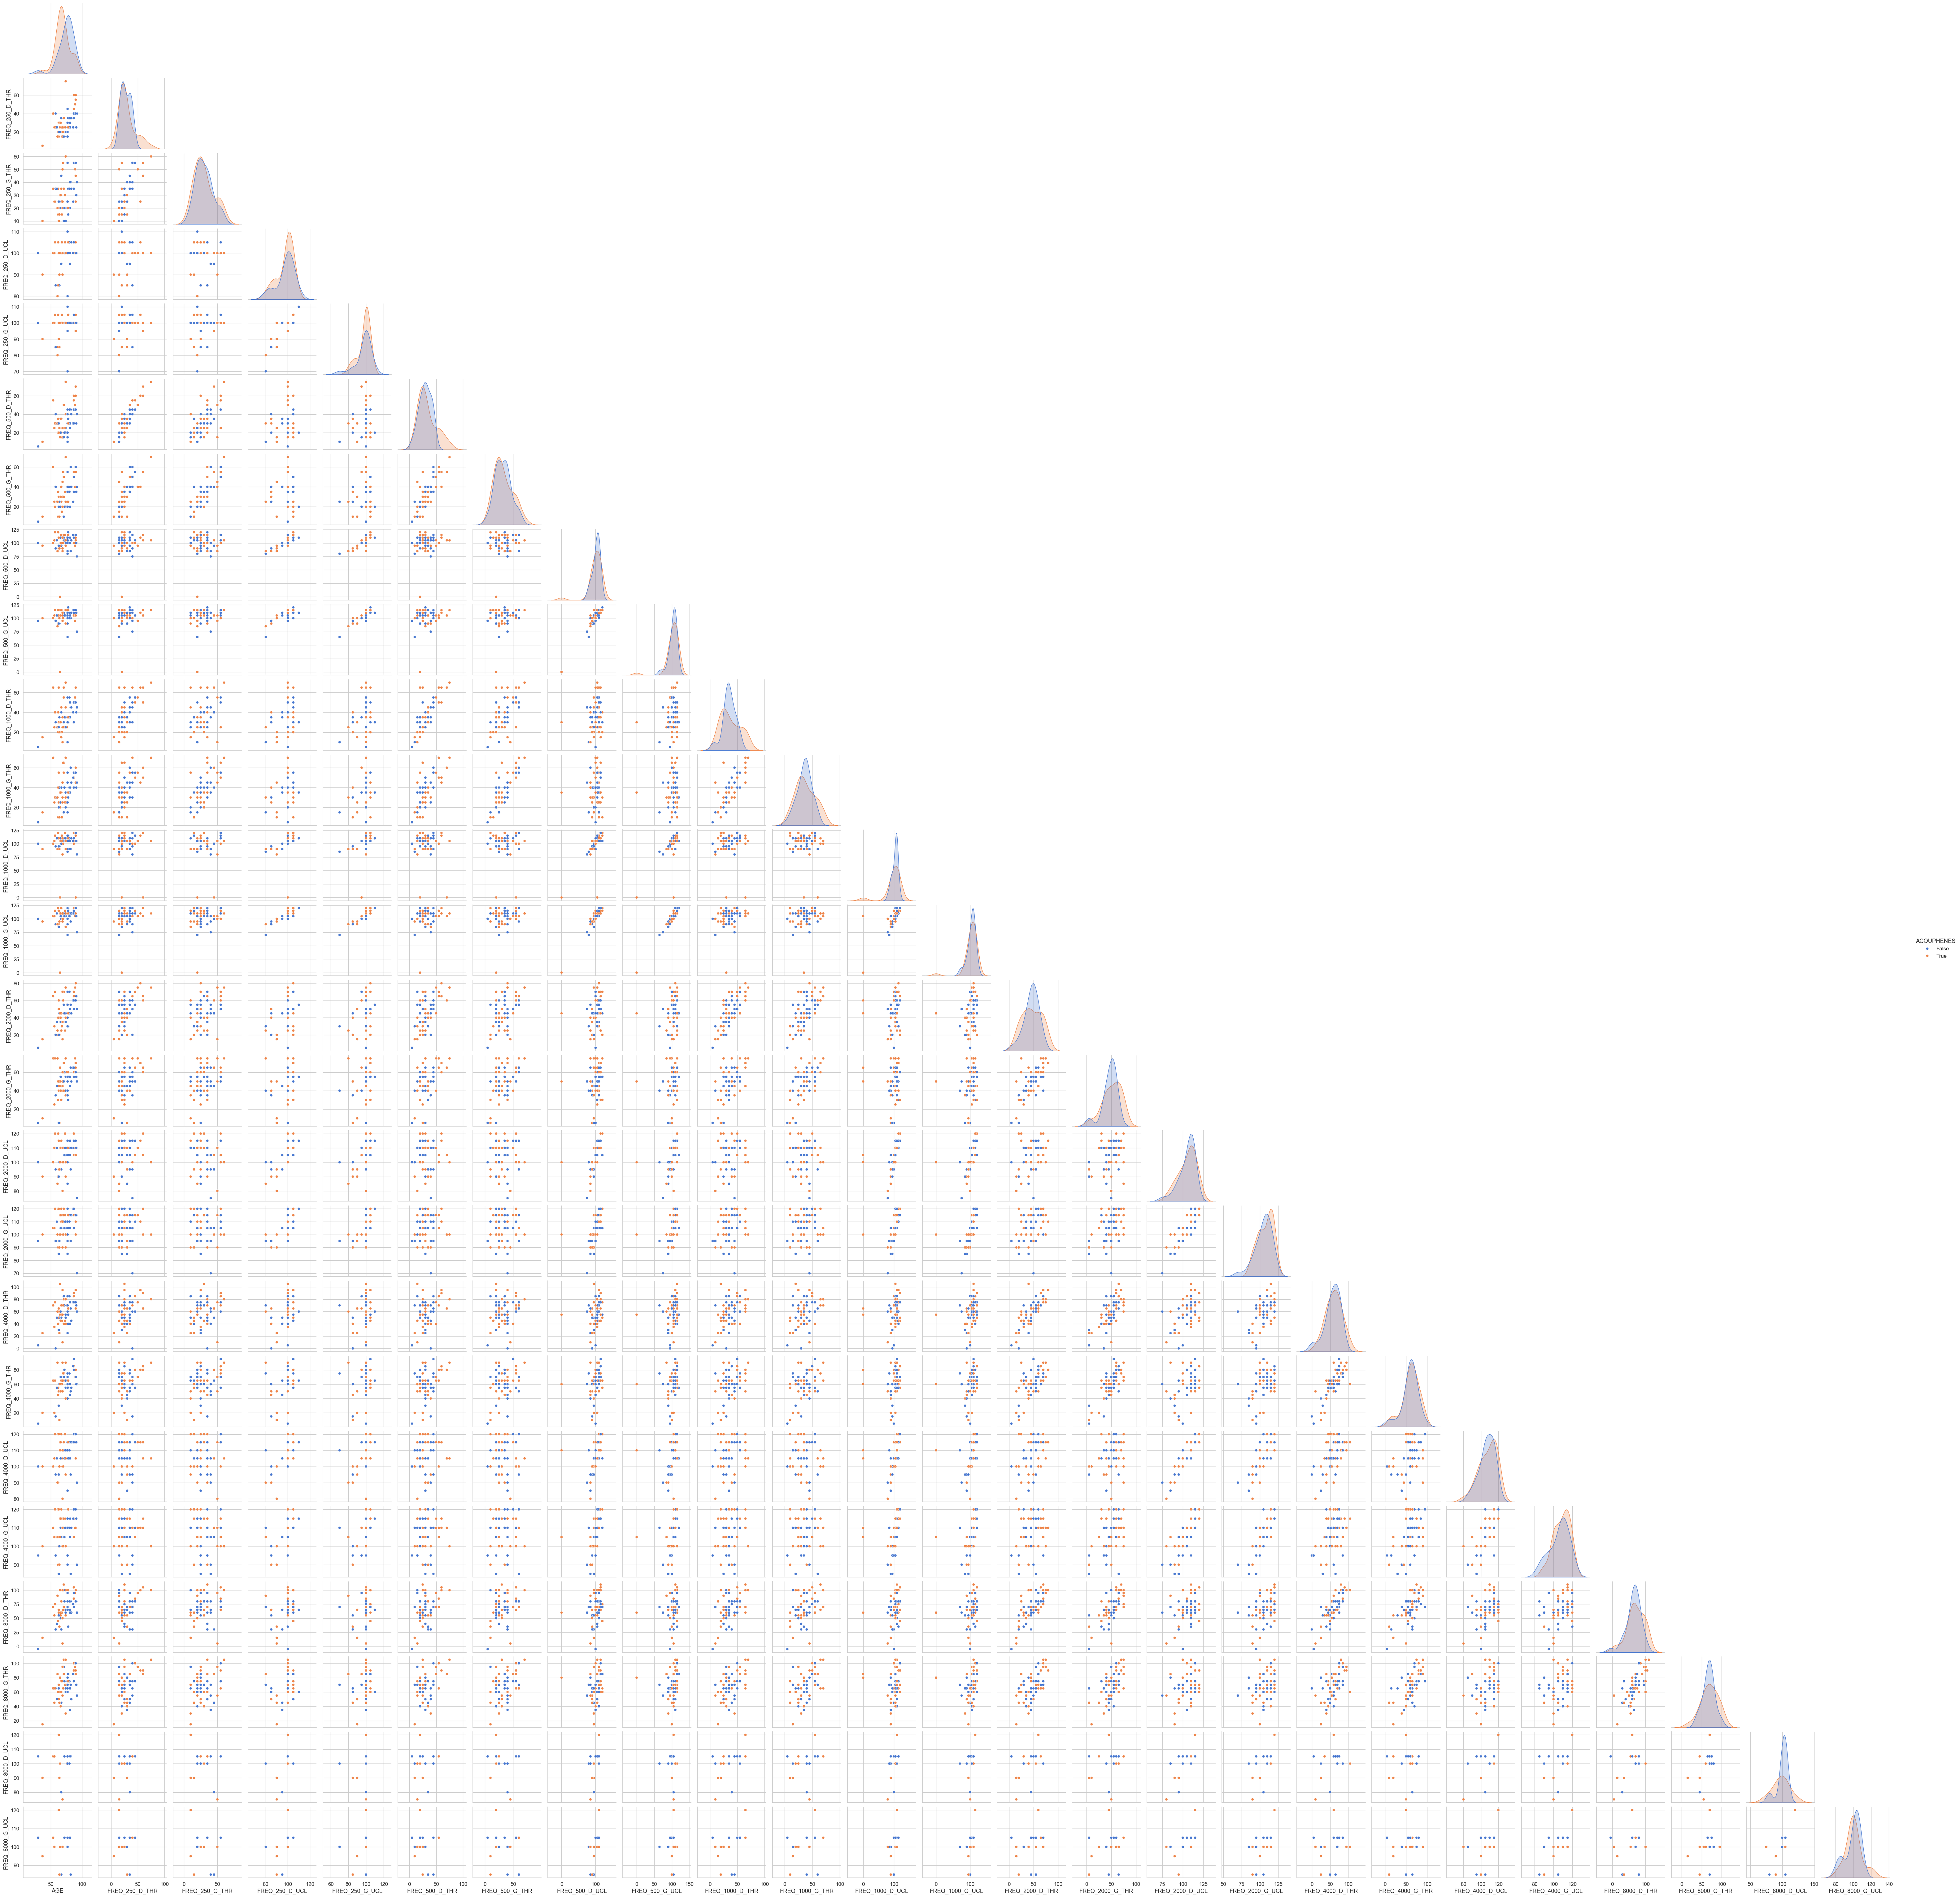

In [13]:
display_statistics(df_final)

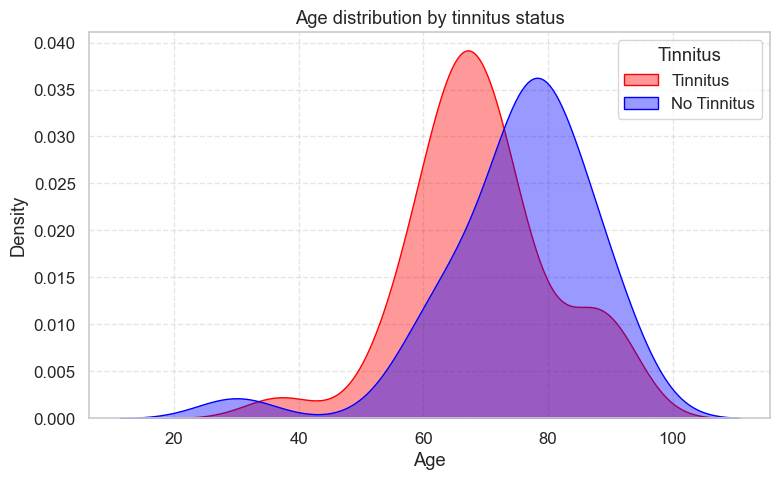

In [28]:
plt.figure(figsize=(8, 5))

# Séparation manuelle pour chaque groupe
sns.kdeplot(
    data=sample_df[sample_df['ACOUPHENES'] == True],
    x="AGE",
    fill=True,
    alpha=0.4,
    label="Tinnitus",
    color='red'
)

sns.kdeplot(
    data=sample_df[sample_df['ACOUPHENES'] == False],
    x="AGE",
    fill=True,
    alpha=0.4,
    label="No Tinnitus",
    color='blue'
)

plt.title("Age distribution by tinnitus status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Tinnitus")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


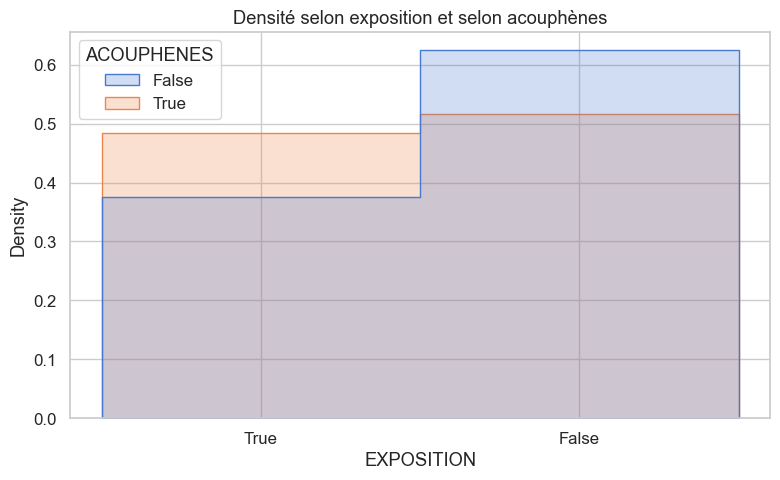

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
df=df_final.copy()
plt.figure(figsize=(8, 5))

sns.histplot(
    data=df,
    x=df['EXPOSITION'].dropna().astype(str),
    hue='ACOUPHENES',
    element='step',
    stat='density',
    common_norm=False
)

plt.title("Densité selon exposition et selon acouphènes")
plt.tight_layout()
plt.show()



In [18]:
import matplotlib.pyplot as plt
import pandas as pd
df=df_final.copy()
# Copier pour éviter warning
df_filtered = df.dropna(subset=['EXPOSITION', 'ACOUPHENES']).copy()

# Assurer que ACOUPHENES est binaire 0/1, sinon ajuster selon tes données
# Puis faire le mapping avec gestion des valeurs non conformes (errors='ignore')
df_filtered['ACOUPHENES'] = df_filtered['ACOUPHENES'].map({0: 'No', 1: 'Yes'})

# Dropper les lignes où mapping a échoué et qui sont devenues NaN
df_filtered = df_filtered.dropna(subset=['ACOUPHENES'])

# Compter par exposition et acouphènes
counts = df_filtered.groupby(['EXPOSITION', 'ACOUPHENES']).size().unstack(fill_value=0)

print(counts)
print(counts.dtypes)  # doit être int64

# Plot empilé
ax = counts.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'lightcoral'],
    figsize=(10, 6)
)

plt.title("Nombre de patients par exposition et présence d'acouphènes")
plt.xlabel("Exposition")
plt.ylabel("Nombre de patients")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Acouphènes')
plt.tight_layout()
plt.show()


Empty DataFrame
Columns: []
Index: []
Series([], dtype: object)


TypeError: no numeric data to plot

1463
0
['Yes' 'No']
ACOUPHENES     No    Yes
EXPOSITION              
False       20330  14598
True        12236  13648


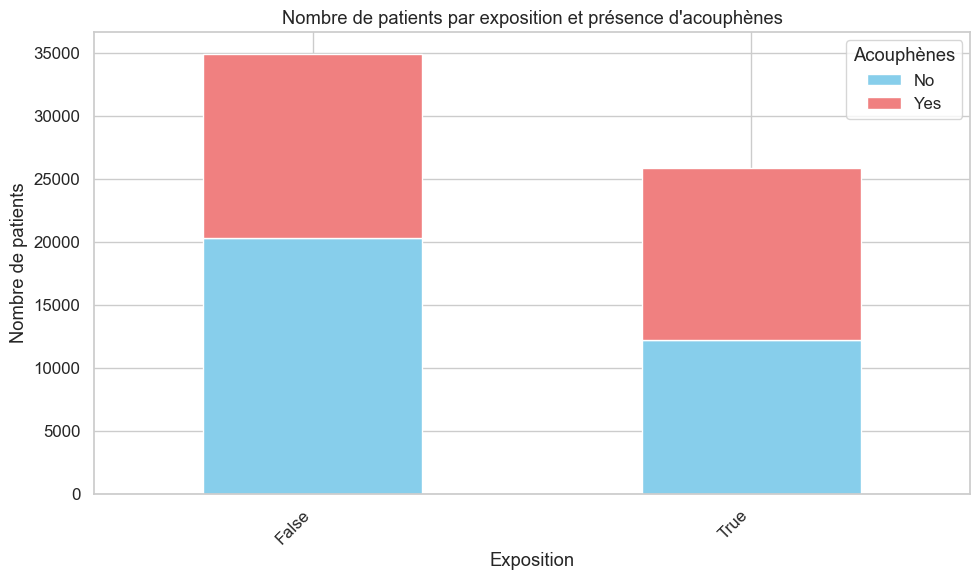

In [21]:
# Vérifions les NaN dans EXPOSTION et ACOUPHENES
print(df['EXPOSITION'].isna().sum())  # nombre de NaN dans EXPOSTION
print(df['ACOUPHENES'].isna().sum())  # nombre de NaN dans ACOUPHENES

# Créons un df filtré qui supprime les NaN dans ces deux colonnes
df_filtered = df.dropna(subset=['EXPOSITION', 'ACOUPHENES']).copy()

# Map booléen vers "Yes"/"No"
df_filtered['ACOUPHENES'] = df_filtered['ACOUPHENES'].map({True: 'Yes', False: 'No'})

print(df_filtered['ACOUPHENES'].unique())  # vérifier que ce sont bien "Yes" et "No"

# Groupons et comptons
counts = df_filtered.groupby(['EXPOSITION', 'ACOUPHENES']).size().unstack(fill_value=0)

print(counts)

# Plot empilé
ax = counts.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'lightcoral'],
    figsize=(10, 6)
)
plt.title("Nombre de patients par exposition et présence d'acouphènes")
plt.xlabel("Exposition")
plt.ylabel("Nombre de patients")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Acouphènes')
plt.tight_layout()
plt.show()


ACOUPHENES     No    Yes
EXPOSITION              
False       20330  14598
True        12236  13648
ACOUPHENES
No     int64
Yes    int64
dtype: object


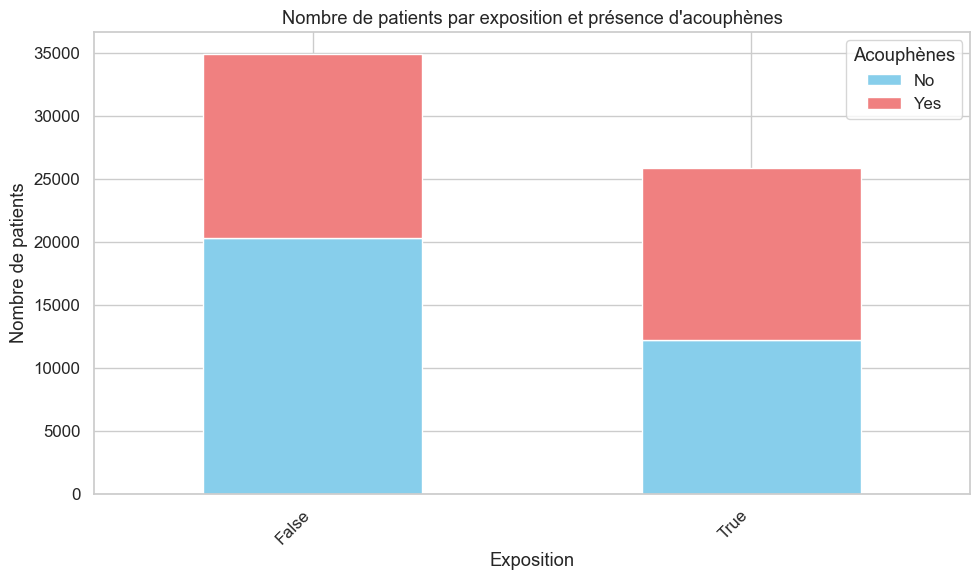

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
# Copier pour éviter warning
df_filtered = df.dropna(subset=['EXPOSITION', 'ACOUPHENES']).copy()

# Assurer que ACOUPHENES est binaire 0/1, sinon ajuster selon tes données
# Puis faire le mapping avec gestion des valeurs non conformes (errors='ignore')
df_filtered['ACOUPHENES'] = df_filtered['ACOUPHENES'].map({False: 'No', True: 'Yes'})

# Dropper les lignes où mapping a échoué et qui sont devenues NaN
df_filtered = df_filtered.dropna(subset=['ACOUPHENES'])

# Compter par exposition et acouphènes
counts = df_filtered.groupby(['EXPOSITION', 'ACOUPHENES']).size().unstack(fill_value=0)

print(counts)
print(counts.dtypes)  # doit être int64

# Plot empilé
ax = counts.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'lightcoral'],
    figsize=(10, 6)
)

plt.title("Nombre de patients par exposition et présence d'acouphènes")
plt.xlabel("Exposition")
plt.ylabel("Nombre de patients")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Acouphènes')
plt.tight_layout()
plt.show()


In [ ]:
# Vérifions les NaN dans EXPOSTION et ACOUPHENES
print(df['EXPOSITION'].isna().sum())  # nombre de NaN dans EXPOSTION
print(df['ACOUPHENES'].isna().sum())  # nombre de NaN dans ACOUPHENES

# Créons un df filtré qui supprime les NaN dans ces deux colonnes
df_filtered = df.dropna(subset=['EXPOSITION', 'ACOUPHENES']).copy()

# Map booléen vers "Yes"/"No"
df_filtered['ACOUPHENES'] = df_filtered['ACOUPHENES'].map({True: 'Yes', False: 'No'})

print(df_filtered['ACOUPHENES'].unique())  # vérifier que ce sont bien "Yes" et "No"

# Groupons et comptons
counts = df_filtered.groupby(['EXPOSITION', 'ACOUPHENES']).size().unstack(fill_value=0)

print(counts)

# Plot empilé
ax = counts.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'lightcoral'],
    figsize=(10, 6)
)

plt.title("Number of patients per exposure and presence of tinnitus")
plt.xlabel("Exposure")
plt.ylabel("Number of patients")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tinnitus')

# Ajout des annotations de pourcentages sur chaque segment de barre
for i, exposition in enumerate(counts.index):
    total = counts.loc[exposition].sum()
    cum_height = 0
    for acouphene_status in counts.columns:
        value = counts.loc[exposition, acouphene_status]
        if value > 0:
            pct = value / total * 100
            height = value
            ax.text(
                i,                          # position x (index de la barre)
                cum_height + height / 2,    # position y (milieu du segment)
                f"{pct:.1f}%",              # texte à afficher
                ha='center', va='center',
                color='black',
                fontsize=13
            )
            cum_height += height

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

C:\Users\benba\AppData\Local\Temp\ipykernel_22676\3611317915.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_age = df_filtered.groupby(['AgeGroup', 'ACOUPHENES']).size().unstack(fill_value=0)


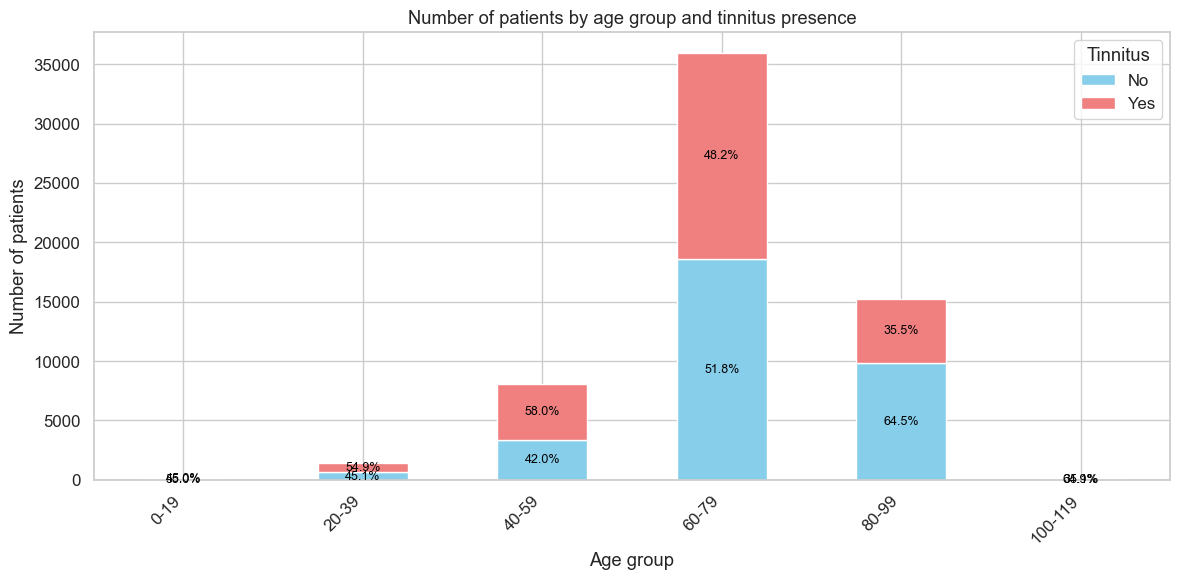

In [24]:
bins = list(range(0, int(df['AGE'].max()) + 20, 20))
labels = [f"{b}-{b+19}" for b in bins[:-1]]

# On ajoute une colonne 'AgeGroup' avec les tranches d'âge
df_filtered['AgeGroup'] = pd.cut(df_filtered['AGE'], bins=bins, labels=labels, right=False)

# Filtrage pour retirer NaN éventuels dans AgeGroup (ex. AGE < 0)
df_filtered = df_filtered.dropna(subset=['AgeGroup'])

# Groupby par tranche d'âge et tinnitus
counts_age = df_filtered.groupby(['AgeGroup', 'ACOUPHENES']).size().unstack(fill_value=0)

# Plot empilé
ax = counts_age.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'lightcoral'],
    figsize=(12, 6)
)

plt.title("Number of patients by age group and tinnitus presence")
plt.xlabel("Age group")
plt.ylabel("Number of patients")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tinnitus')

# Ajout des pourcentages sur chaque segment
for i, age_group in enumerate(counts_age.index):
    total = counts_age.loc[age_group].sum()
    cum_height = 0
    for tinnitus_status in counts_age.columns:
        value = counts_age.loc[age_group, tinnitus_status]
        if value > 0:
            pct = value / total * 100
            height = value
            ax.text(
                i,
                cum_height + height / 2,
                f"{pct:.1f}%",
                ha='center', va='center',
                color='black',
                fontsize=9
            )
            cum_height += height

plt.tight_layout()
plt.show()

C:\Users\benba\AppData\Local\Temp\ipykernel_22676\2064328903.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_age = df_filtered.groupby(['AgeGroup', 'ACOUPHENES']).size().unstack(fill_value=0)


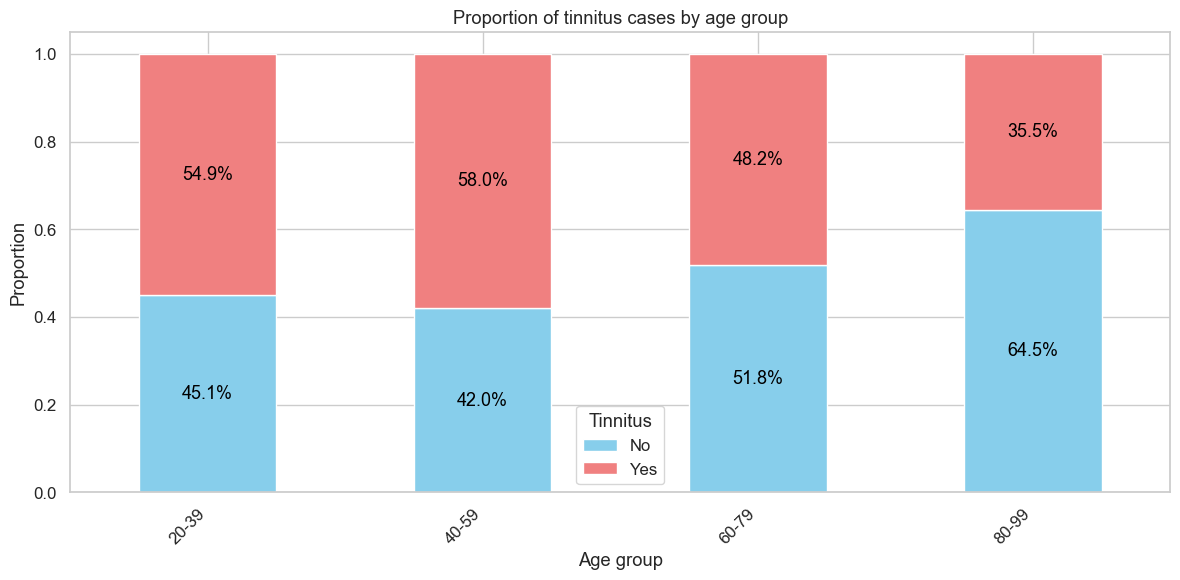

In [25]:
import numpy as np

# Définition des bornes d'âge (20 à 100 ans)
bins = list(range(20, 101, 20))  # [20, 40, 60, 80, 100]
labels = [f"{b}-{b+19}" for b in bins[:-1]]  # ['20-39', '40-59', '60-79', '80-99']

# Ajout colonne 'AgeGroup' avec les tranches
df_filtered['AgeGroup'] = pd.cut(df_filtered['AGE'], bins=bins, labels=labels, right=False)

# Retirer les lignes hors de ces tranches
df_filtered = df_filtered.dropna(subset=['AgeGroup'])

# Comptage par tranche d'âge et tinnitus
counts_age = df_filtered.groupby(['AgeGroup', 'ACOUPHENES']).size().unstack(fill_value=0)

# Normalisation pour avoir proportions par groupe d'âge
proportions = counts_age.div(counts_age.sum(axis=1), axis=0)

# Plot empilé en proportion
ax = proportions.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'lightcoral'],
    figsize=(12, 6)
)

plt.title("Proportion of tinnitus cases by age group")
plt.xlabel("Age group")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tinnitus')

# Ajout des pourcentages sur chaque segment
for i, age_group in enumerate(proportions.index):
    cum_height = 0
    for tinnitus_status in proportions.columns:
        value = proportions.loc[age_group, tinnitus_status]
        if value > 0:
            ax.text(
                i,
                cum_height + value / 2,
                f"{value * 100:.1f}%",
                ha='center', va='center',
                color='black',
                fontsize=13
            )
            cum_height += value

plt.tight_layout()
plt.show()


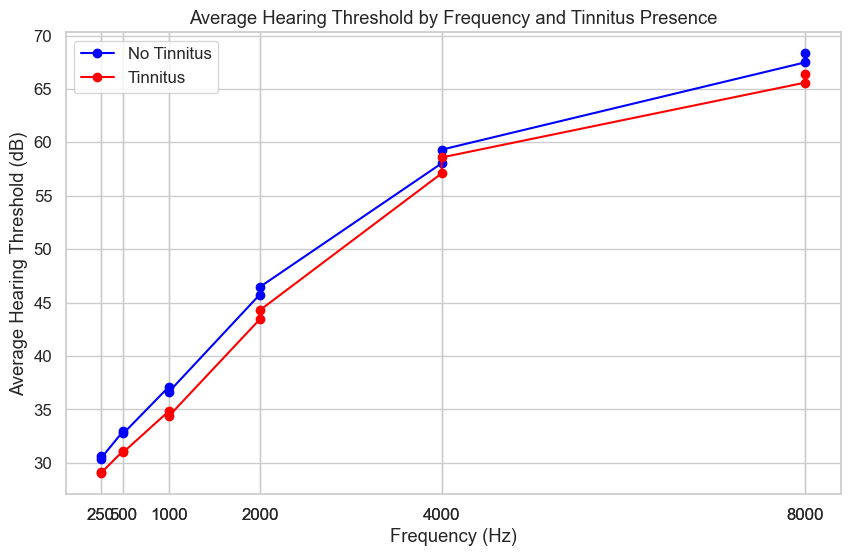

In [ ]:
# Assure-toi que la colonne est bien booléenne
df['ACOUPHENES'] = df['ACOUPHENES'].astype(bool)

# Moyennes par groupe ACOUPHENES
mean_thr = df.groupby('ACOUPHENES')[thr_cols].mean()

# Préparation des fréquences extraites des noms de colonnes (ex: 'FREQ_250_D_THR' -> 250)
freqs = [int(col.split('_')[1]) for col in thr_cols]

plt.figure(figsize=(10, 6))

plt.plot(freqs, mean_thr.loc[False], marker='o', label='No Tinnitus', color='blue')
plt.plot(freqs, mean_thr.loc[True], marker='o', label='Tinnitus', color='red')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Hearing Threshold (dB)')
plt.title('Average Hearing Threshold by Frequency and Tinnitus Presence')
plt.legend()
plt.grid(True)
plt.xticks(freqs)
plt.show()


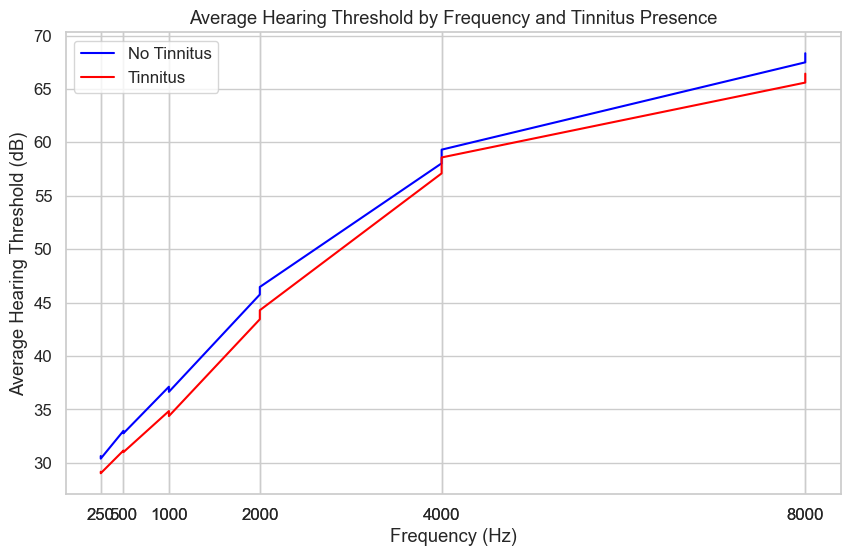

In [ ]:
# 1. Extraire les colonnes triées
thr_cols = sorted(thr_cols, key=lambda x: int(x.split('_')[1]))

# 2. Extraire les fréquences en entiers
freqs = np.array([int(col.split('_')[1]) for col in thr_cols])

# 3. Assure-toi que les colonnes sont dans le bon ordre
mean_thr = mean_thr[thr_cols]

# 4. Convertir les valeurs moyennes en array pour correspondre à freqs
no_tinnitus = mean_thr.loc[False].values.astype(float)
tinnitus = mean_thr.loc[True].values.astype(float)

# 5. Tracé
plt.figure(figsize=(10, 6))
plt.plot(freqs, no_tinnitus,  label='No Tinnitus', color='blue')
plt.plot(freqs, tinnitus, label='Tinnitus', color='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Hearing Threshold (dB)')
plt.title('Average Hearing Threshold by Frequency and Tinnitus Presence')
plt.legend()
plt.grid(True)
plt.xticks(freqs)
plt.show()


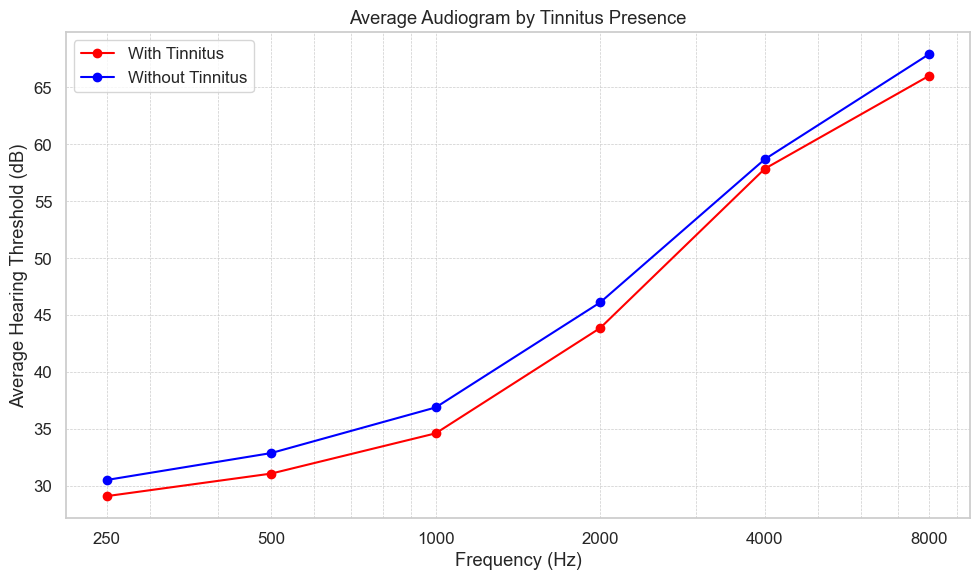

In [ ]:
# Frequencies to consider
freqs = [250, 500, 1000, 2000, 4000, 8000]
 
# Masks to separate subjects with / without tinnitus
mask_with    = df['ACOUPHENES'] == 1
mask_without = df['ACOUPHENES'] == 0
 
# Compute means (Right + Left) / 2 for each frequency and each group
means_with    = []
means_without = []
 
for f in freqs:
    thr_d_w = df.loc[mask_with,    f'FREQ_{f}_D_THR']
    thr_g_w = df.loc[mask_with,    f'FREQ_{f}_G_THR']
    means_with.append((thr_d_w.mean() + thr_g_w.mean()) / 2)
 
    thr_d_wo = df.loc[mask_without, f'FREQ_{f}_D_THR']
    thr_g_wo = df.loc[mask_without, f'FREQ_{f}_G_THR']
    means_without.append((thr_d_wo.mean() + thr_g_wo.mean()) / 2)
 
# Plot
plt.figure()
plt.plot(freqs, means_with,    color='red',  marker='o', label='With Tinnitus')
plt.plot(freqs, means_without, color='blue', marker='o', label='Without Tinnitus')
 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Hearing Threshold (dB)')
plt.title('Average Audiogram by Tinnitus Presence')
plt.xscale('log')
plt.xticks(freqs, freqs)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


C:\Users\benba\AppData\Local\Temp\ipykernel_12844\2806036650.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../Data/Cleaned_Dataframe.csv', sep=';')


Correlation with ACOUPHENES (Age + THR only):

FREQ_4000_G_THR   -0.012341
FREQ_4000_D_THR   -0.018705
FREQ_8000_D_THR   -0.030316
FREQ_250_G_THR    -0.031635
FREQ_8000_G_THR   -0.035665
FREQ_500_G_THR    -0.045627
FREQ_250_D_THR    -0.047195
FREQ_2000_G_THR   -0.054529
FREQ_1000_G_THR   -0.056578
FREQ_500_D_THR    -0.057331
FREQ_2000_D_THR   -0.065740
FREQ_1000_D_THR   -0.069884
AGE               -0.134791
Name: ACOUPHENES_BIN, dtype: float64


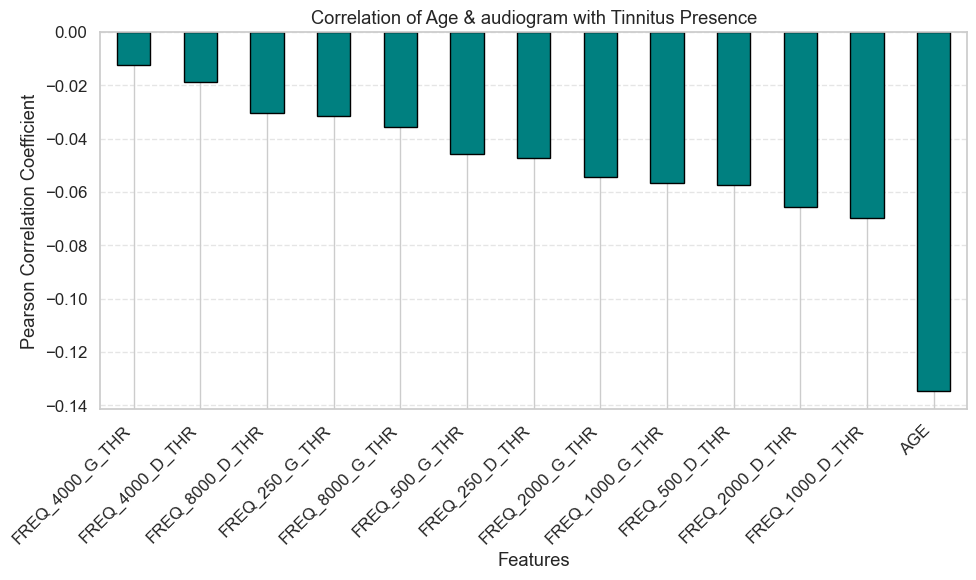

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Préparation : lecture et encodage de la cible
df = pd.read_csv('../../Data/Cleaned_Dataframe.csv', sep=';')
df = df.dropna().copy()
df['ACOUPHENES_BIN'] = df['ACOUPHENES'].map({True: 1, False: 0})

# 2. Sélection : Age + toutes les colonnes THR
thr_cols = [c for c in df.columns if c.endswith('_THR')]
selected = ['AGE'] + thr_cols + ['ACOUPHENES_BIN']
df_sel = df[selected]

# 3. Calcul des corrélations
corr_with_target = df_sel.corr()['ACOUPHENES_BIN'].drop('ACOUPHENES_BIN').sort_values(ascending=False)

# 4. Affichage console
print("Correlation with ACOUPHENES (Age + THR only):\n")
print(corr_with_target)

# 5. Bar plot des corrélations
plt.figure(figsize=(10, 6))
corr_with_target.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Correlation of Age & audiogram with Tinnitus Presence')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
